# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.0.0'

#### Load Image Data

In [2]:
DATA_LIST = os.listdir('all/train')
DATASET_PATH  = 'all/train'
TEST_DIR =  'all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [4]:
vgg_16 = VGG16(weights = 'imagenet', include_top = False, \
              input_shape = (224,224,3), classes = NUM_CLASSES)

for layer in vgg_16.layers:
    layer.trainable = False

model = tf.keras.models.Sequential()

model.add(vgg_16)

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(.15))

model.add(tf.keras.layers.Dense(256, activation = 'relu'))

model.add(tf.keras.layers.Dropout(.15))

model.add(tf.keras.layers.Dense(4, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 21,138,500
Trainable params: 6,423,812
Non-trainable params: 14,714,688
____________________________________

#### [5 points] Train Model

In [5]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

model.compile(optimizer = OPTIMIZER, \
                loss=tf.keras.losses.CategoricalCrossentropy(), \
                metrics=['accuracy'])


history = model.fit(train_batches, steps_per_epoch = STEP_SIZE_TRAIN, \
                    epochs = NUM_EPOCHS, validation_data = valid_batches, \
                    validation_steps = STEP_SIZE_VALID)

22
6
Train for 21 steps, validate for 5 steps
Epoch 1/100
21/21 [==============================] - 43s 2s/step - loss: 1.6210 - accuracy: 0.3155 - val_loss: 1.3986 - val_accuracy: 0.3000
Epoch 2/100
21/21 [==============================] - 41s 2s/step - loss: 1.2517 - accuracy: 0.4806 - val_loss: 1.0832 - val_accuracy: 0.5400
Epoch 3/100
21/21 [==============================] - 41s 2s/step - loss: 1.1095 - accuracy: 0.4951 - val_loss: 1.1909 - val_accuracy: 0.4200
Epoch 4/100
21/21 [==============================] - 42s 2s/step - loss: 1.0529 - accuracy: 0.5243 - val_loss: 0.8222 - val_accuracy: 0.6800
Epoch 5/100
21/21 [==============================] - 42s 2s/step - loss: 0.9475 - accuracy: 0.5631 - val_loss: 0.8431 - val_accuracy: 0.6200
Epoch 6/100
21/21 [==============================] - 43s 2s/step - loss: 0.9346 - accuracy: 0.6214 - val_loss: 0.8780 - val_accuracy: 0.5800
Epoch 7/100
21/21 [==============================] - 42s 2s/step - loss: 0.9054 - accuracy: 0.5971 - val_los

#### [5 points] Plot Accuracy and Loss During Training

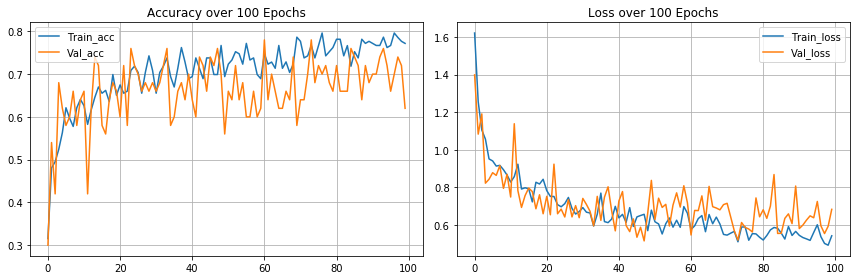

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12,4))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(history.history['accuracy'], label='Train_acc')
plt.plot(history.history['val_accuracy'], label = 'Val_acc')
plt.title("Accuracy over 100 Epochs")
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.grid()
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label = 'Val_loss')
plt.title("Loss over 100 Epochs")
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Testing Model

In [10]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
36/36 [==============================] - 6s 179ms/step - loss: 0.7886 - accuracy: 0.6667
Test loss: 0.7885822096375503
Test accuracy: 0.6666667


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 270 images belonging to 4 classes.


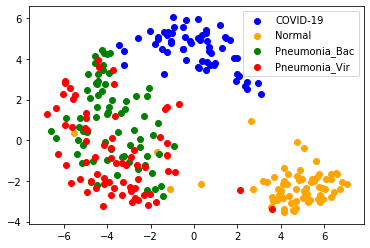

In [8]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=model.input, \
                                        outputs=model.get_layer('dense').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE, \
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")

features = intermediate_layer_model.predict_generator(tsne_eval_generator)

labels = tsne_eval_generator.labels

tsne = TSNE(perplexity = 75, learning_rate = 80).fit_transform(features)

for i in range(len(tsne)):
    if labels[i] == 0: 
        # covid
        c = plt.scatter(tsne[:,0][i], tsne[:,1][i], color = 'blue')
    elif labels[i] == 1:
        # normal
        n = plt.scatter(tsne[:,0][i], tsne[:,1][i], color = 'orange')
    elif labels[i] == 2:
        # pneumonia_bac
        pb = plt.scatter(tsne[:,0][i], tsne[:,1][i], color = 'green')
    else:
        # pneumonia_vir
        pv = plt.scatter(tsne[:,0][i], tsne[:,1][i], color = 'red')               

plt.legend((c, n, pb, pv), ("COVID-19", "Normal", "Pneumonia_Bac", \
                            "Pneumonia_Vir"))

plt.show()